In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [4]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu

In [5]:
import scanpy as sc

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

## Create dataloaders

Note: samples must have the same number of genes (and of course in the same order). They can, however, have different number of cells, but you'll only be able to use `batch_size = 1`, because we matrices with different sizes cannot form a tensor.

It is possible in the future, by flanking them with zeros and carefully masking them out in several steps.

In [7]:
adata = sc.read_h5ad('data/demo1_sp_adata.h5ad')

train_Xs = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    train_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
validate_Xs = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)
Validation data dimensions:
(5000, 374)


In [8]:
model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_embed=[512, 256, 128], 
                      d_quality=[512, 256, 1], 
                      n_heads=4,
                      lbd=1.).to('cuda')

In [9]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 500],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)

Epoch 0001 Train MSE 2310.292 Validate MSE 1.025 Raw MSE 0.988
Epoch 0002 Train MSE 2310.282 Validate MSE 1.048 Raw MSE 1.012
Epoch 0003 Train MSE 2310.279 Validate MSE 1.033 Raw MSE 1.002
Epoch 0004 Train MSE 2310.300 Validate MSE 1.041 Raw MSE 1.004
Epoch 0005 Train MSE 2310.277 Validate MSE 1.035 Raw MSE 1.005
Epoch 0006 Train MSE 2310.279 Validate MSE 1.029 Raw MSE 0.997
Epoch 0007 Train MSE 2310.284 Validate MSE 1.037 Raw MSE 1.008
Epoch 0008 Train MSE 2310.285 Validate MSE 1.036 Raw MSE 1.004
Epoch 0009 Train MSE 2310.285 Validate MSE 1.050 Raw MSE 1.025
Epoch 0010 Train MSE 2310.275 Validate MSE 1.010 Raw MSE 0.981
Epoch 0011 Train MSE 2310.297 Validate MSE 1.006 Raw MSE 0.980
Epoch 0012 Train MSE 2310.295 Validate MSE 1.029 Raw MSE 1.008
Epoch 0013 Train MSE 2310.284 Validate MSE 1.048 Raw MSE 1.030
Epoch 0014 Train MSE 2310.267 Validate MSE 0.995 Raw MSE 0.977
Epoch 0015 Train MSE 2310.260 Validate MSE 1.061 Raw MSE 1.045
Epoch 0016 Train MSE 2310.272 Validate MSE 1.037 Raw MS

In [10]:
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [500, 750],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [750, 1000],
                                           fix=['interact'], lr=1e-4))

Epoch 0501 Train MSE 2310.239 Validate MSE 0.996 Raw MSE 1.028
Epoch 0502 Train MSE 2310.243 Validate MSE 0.967 Raw MSE 0.988
Epoch 0503 Train MSE 2310.217 Validate MSE 0.981 Raw MSE 1.017
Epoch 0504 Train MSE 2310.206 Validate MSE 0.972 Raw MSE 1.024
Epoch 0505 Train MSE 2310.222 Validate MSE 0.929 Raw MSE 0.988
Epoch 0506 Train MSE 2310.195 Validate MSE 0.941 Raw MSE 0.997
Epoch 0507 Train MSE 2310.197 Validate MSE 0.936 Raw MSE 1.002
Epoch 0508 Train MSE 2310.186 Validate MSE 0.949 Raw MSE 1.024
Epoch 0509 Train MSE 2310.195 Validate MSE 0.938 Raw MSE 1.018
Epoch 0510 Train MSE 2310.199 Validate MSE 0.926 Raw MSE 0.991
Epoch 0511 Train MSE 2310.183 Validate MSE 0.921 Raw MSE 0.990
Epoch 0512 Train MSE 2310.180 Validate MSE 0.944 Raw MSE 1.028
Epoch 0513 Train MSE 2310.169 Validate MSE 0.935 Raw MSE 1.017
Epoch 0514 Train MSE 2310.181 Validate MSE 0.931 Raw MSE 1.014
Epoch 0515 Train MSE 2310.179 Validate MSE 0.933 Raw MSE 1.023
Epoch 0516 Train MSE 2310.174 Validate MSE 0.937 Raw MS

In [11]:
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1000, 1250],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1250, 1500], lr=1e-4))

Epoch 1001 Train MSE 2306.838 Validate MSE 0.867 Raw MSE 1.034
Epoch 1002 Train MSE 2297.021 Validate MSE 0.836 Raw MSE 0.983
Epoch 1003 Train MSE 2287.252 Validate MSE 0.857 Raw MSE 0.996


Epoch 1004 Train MSE 2277.510 Validate MSE 0.869 Raw MSE 1.043
Epoch 1005 Train MSE 2267.792 Validate MSE 0.854 Raw MSE 1.004
Epoch 1006 Train MSE 2258.103 Validate MSE 0.863 Raw MSE 1.013
Epoch 1007 Train MSE 2248.419 Validate MSE 0.858 Raw MSE 0.997
Epoch 1008 Train MSE 2238.793 Validate MSE 0.880 Raw MSE 1.028
Epoch 1009 Train MSE 2229.173 Validate MSE 0.859 Raw MSE 1.021
Epoch 1010 Train MSE 2219.600 Validate MSE 0.870 Raw MSE 1.032
Epoch 1011 Train MSE 2210.055 Validate MSE 0.856 Raw MSE 1.005
Epoch 1012 Train MSE 2200.512 Validate MSE 0.847 Raw MSE 1.012
Epoch 1013 Train MSE 2191.007 Validate MSE 0.875 Raw MSE 1.034
Epoch 1014 Train MSE 2181.527 Validate MSE 0.860 Raw MSE 1.011
Epoch 1015 Train MSE 2172.081 Validate MSE 0.855 Raw MSE 1.012
Epoch 1016 Train MSE 2162.654 Validate MSE 0.854 Raw MSE 1.005
Epoch 1017 Train MSE 2153.256 Validate MSE 0.867 Raw MSE 1.030
Epoch 1018 Train MSE 2143.878 Validate MSE 0.832 Raw MSE 1.002
Epoch 1019 Train MSE 2134.540 Validate MSE 0.834 Raw MS

Text(0, 0.5, 'MSE')

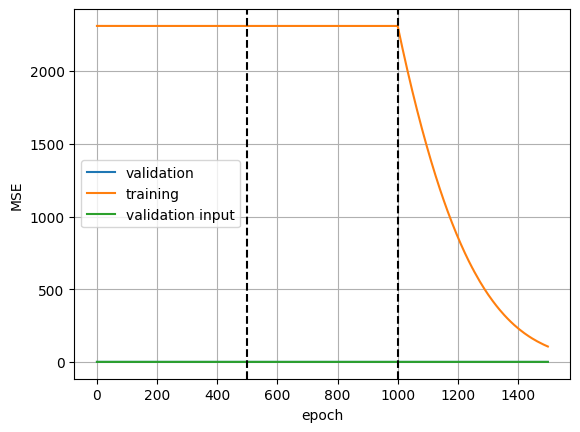

In [12]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(500, ls='--', c='k')
plt.axvline(1000, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [13]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 250: return 'pre-denoise'
    elif x < 500: return 'denoise'
    elif x < 750: return 'pre-denoise-smooth'
    elif x < 1000: return 'denoise-smooth'
    elif x < 1250: return 'pre-denoise-smooth-enhance'
    elif x < 1500: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 400 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

,epoch,mse,stage
0,0,1.025302,pre-denoise
1,1,1.047535,pre-denoise
2,2,1.033468,pre-denoise
3,3,1.041028,pre-denoise
4,4,1.034816,pre-denoise
...,...,...,...
1495,1495,0.847070,denoise-smooth-enhance
1496,1496,0.833717,denoise-smooth-enhance
1497,1497,0.856099,denoise-smooth-enhance
1498,1498,0.856822,denoise-smooth-enhance


/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


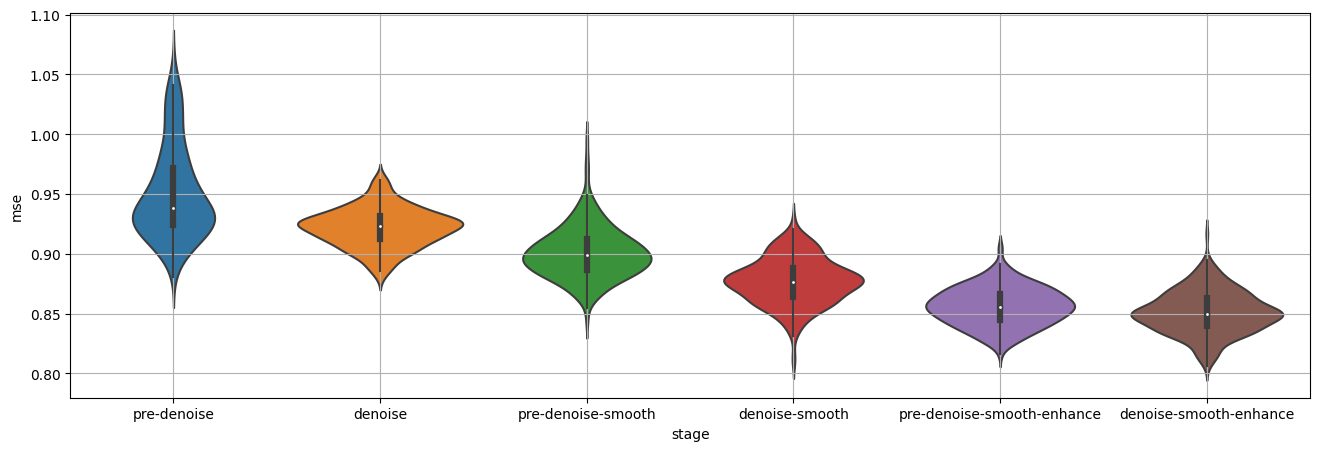

In [14]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()

In [15]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 3.1795733326504316e-71 f = 0.961216


In [16]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 2.508923984859228e-40 f = 0.8436


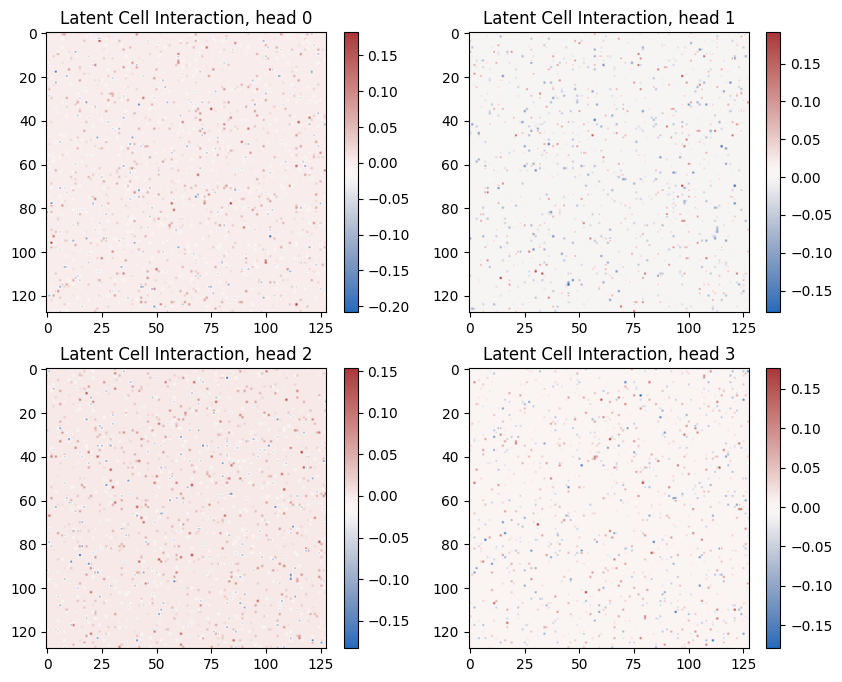

In [17]:
# Plot heatmap of the parameters in cell interaction module

weight_CIs = []
for head in range(len(model.cell_interacts)):
    weight_CIs.append(model.cell_interacts[head].transform.data)

plt.figure(figsize=(10, 8))
for i, weight_CI in enumerate(weight_CIs):
    weight_array = weight_CI.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Latent Cell Interaction, head {i}')
plt.show()